In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBClassifier
import statsmodels.api as sm

## Load Data

In [2]:
df = pd.read_csv('../data/data_modeling.csv',sep=',')
df.head(2)

,age,default,balance,housing,loan,duration,campaign,previous,y,contact_group,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,4.350000,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,2.516667,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [3]:
y = df['y'].values
X = df.drop(labels = ['y'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (45206, 25) and that of y is (45206,)


## Class Imbalance (SMOTE)

In [4]:
X_sm, y_sm = over_sampling.SMOTE(0.5).fit_resample(X, y)
print("Shape of X is {} and that of y is {}".format(X_sm.shape, y_sm.shape))

Shape of X is (59878, 25) and that of y is (59878,)


## Split Train-Test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 42)

Add constraint for Logistic Regression using statsmodel

In [6]:
X_train_stat = sm.add_constant(X_train)
X_test_stat = sm.add_constant(X_test)

## Modeling

In [7]:
def eval_classification(model, xtrain, ytrain, xtest, ytest):
    ypred = model.predict(xtest)
    ypred = (ypred > 0.5).astype(int)
    y_train = model.predict(xtrain)
    y_train = (y_train > 0.5).astype(int)
    
    return accuracy_score(ytest, ypred), precision_score(ytest, ypred), recall_score(ytest, ypred), roc_auc_score(ytest, ypred), f1_score(ytest, ypred), f1_score(ytrain, y_train)
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

### Model Selection

In [8]:
models = {
    "KNN" : KNeighborsClassifier(),
    "AdaBoost" :AdaBoostClassifier(random_state=42),
    "XGBoost" : XGBClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "Logistic Regression Statsmodel" : sm.Logit(y_train,X_train_stat),
    "Logistic Regression" : LogisticRegression(random_state=42)
    }

In [9]:
scores = []
for model in models:
  print("Model "+model + " score:")
  classifier = models[model]
  if model!="Logistic Regression Statsmodel" :
    classifier.fit(X_train, y_train)
    score = eval_classification(classifier,X_train,y_train,X_test,y_test)
  else:
    result = classifier.fit_regularized(random_state = 42)
    score = eval_classification(result, X_train_stat, y_train, X_test_stat, y_test)

  scores.append([model,score[0],score[1], score[2], score[3], score[4], score[5]])

  print("Accuracy (Test Set): %.2f" % score[0])
  print("Precision (Test Set): %.2f" % score[1])
  print("Recall (Test Set): %.2f" % score[2])
  print("AUC (Test Set) : %.2f" % score[3])
  print("F1-Score (Test Set): %.2f" % score[4])
  print("F1-Score (Train Set): %.2f" % score[5])
  print()

Model KNN score:
Accuracy (Test Set): 0.85
Precision (Test Set): 0.75
Recall (Test Set): 0.85
AUC (Test Set) : 0.85
F1-Score (Test Set): 0.79
F1-Score (Train Set): 0.86

Model AdaBoost score:
Accuracy (Test Set): 0.90
Precision (Test Set): 0.88
Recall (Test Set): 0.82
AUC (Test Set) : 0.88
F1-Score (Test Set): 0.85
F1-Score (Train Set): 0.85

Model XGBoost score:
[23:30:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.91
Precision (Test Set): 0.90
Recall (Test Set): 0.84
AUC (Test Set) : 0.89
F1-Score (Test Set): 0.87
F1-Score (Train Set): 0.92

Model Decision Tree score:
Accuracy (Test Set): 0.88
Precision (Test Set): 0.81
Recall (Test Set): 0.83
AUC (Test Set) : 0.86
F1-Score (Test Set): 0.82
F1-Score (Train Set): 1.00

Model Random Forest score:
Accuracy (Test Set): 0

Evaluation metric used in this model is F1, because the dataset has an imbalance target and we want to focuses on predicted positive label correctly. Recall is also used as a supporting metric because in this case we are trying to reduce the number of false negatives.

In [10]:
eval = pd.DataFrame(scores)
eval = eval.rename({0:'Model', 1: 'Accuracy', 2: 'Precision', 3: 'Recall', 4: 'AUC', 5: 'F1(test)', 6: 'F1(train)'}, axis = 1)
eval.sort_values(['F1(test)','Recall','F1(train)'], ascending=False).reset_index().drop('index', axis = 1)

,Model,Accuracy,Precision,Recall,AUC,F1(test),F1(train)
0,Random Forest,0.916555,0.897054,0.846141,0.898886,0.870854,0.999928
1,XGBoost,0.913661,0.897091,0.836263,0.894239,0.865610,0.917607
2,Logistic Regression Statsmodel,0.911044,0.923196,0.798929,0.882910,0.856579,0.863188
3,AdaBoost,0.901692,0.880036,0.815503,0.880064,0.846542,0.853548
4,Decision Tree,0.876475,0.805900,0.827892,0.864284,0.816748,1.000000
5,Logistic Regression,0.878591,0.857466,0.761426,0.849190,0.806597,0.813364
6,KNN,0.853707,0.745055,0.851331,0.853111,0.794655,0.862787


Based on metrics evaluation, Random Forest has the highest F1 and Recall score, thus, we take Random Forest to be used in our model. But, Random Forest has an indication of overfitting based on the test score and the train score, so we have to tuned the hyperparameter of it to make the model more robust.

### Hyperparameter Tuning

In [11]:
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1800, num = 23)],
                       bootstrap = [True],
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(1, 110, num = 25)], 
                       min_samples_split = [5, 10, 15, 20, 25],
                       min_samples_leaf = [1, 3, 5, 7, 9],
                       max_features = ['auto', 'sqrt', 'log2'], 
                       n_jobs = [-1],
                      )

rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=7, random_state=42)
rf_tuned.fit(X_train,y_train)

score = eval_classification(rf_tuned,X_train,y_train,X_test,y_test)
print("Accuracy (Test Set): ", score[0])
print("Precision (Test Set): ", score[1])
print("Recall (Test Set): ", score[2])
print("AUC (Test Set) : ", score[3])
print("F1-Score (Test Set): ", score[4])
print("F1-Score (Train Set): ", score[5])

Accuracy (Test Set):  0.9143286573146293
Precision (Test Set):  0.9032375409239723
Recall (Test Set):  0.831408002678721
AUC (Test Set) :  0.8935206971945852
F1-Score (Test Set):  0.8658355853892424
F1-Score (Train Set):  0.9172641824869041


In [12]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 100
Best bootstrap: True
Best criterion: entropy
Best max_depth: 100
Best min_samples_split: 15
Best min_samples_leaf: 3
Best max_features: log2
Best n_jobs: -1


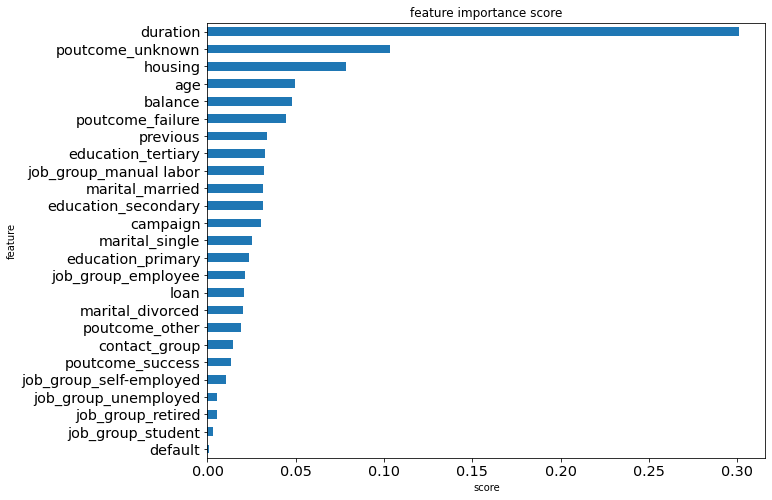

In [13]:
show_feature_importance(rf_tuned.best_estimator_)